### 1. IMPORT LIBRARIES

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

### 2. LOAD DATA

In [6]:
df = pd.read_csv("Sales Dataset.csv")

# Backup copy
df_raw = df.copy()

### 3. DATA CLEANING

In [7]:
# 3.1 Remove Duplicates
df.drop_duplicates(inplace=True)

# 3.2 Missing Values Check
print("Missing Values per Column:\n", df.isnull().sum())

# (Tidak ada missing → aman, kalau ada bisa imputasi)

# 3.3 Convert Date
df["Order Date"] = pd.to_datetime(df["Order Date"], errors='coerce')

# 3.4 Outlier Detection (IQR Method)
num_cols = ["Amount","Profit","Quantity"]

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Outlier mask
outlier_mask = ((df[num_cols] < (Q1 - 1.5 * IQR)) | 
                (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

print("Jumlah Outlier:", outlier_mask.sum())

Missing Values per Column:
 Order ID        0
Amount          0
Profit          0
Quantity        0
Category        0
Sub-Category    0
PaymentMode     0
Order Date      0
CustomerName    0
State           0
City            0
Year-Month      0
dtype: int64
Jumlah Outlier: 10


### 4. FEATURE ENGINEERING

In [8]:
df["Year"]  = df["Order Date"].dt.year
df["Month"] = df["Order Date"].dt.month

# Frequency Encoding for City & Sub-Category
for col in ["City","Sub-Category"]:
    freq = df[col].value_counts(normalize=True)
    df[f"{col}_freq"] = df[col].map(freq)

### 5. FEATURE SELECTION

In [9]:
num_features  = ["Amount","Profit","Quantity"]
cat_features  = ["Category","PaymentMode"]
freq_features = ["City_freq","Sub-Category_freq"]
time_features = ["Year","Month"]

all_features  = num_features + cat_features + freq_features + time_features

### 6. PREPROCESSING PIPELINE

In [10]:
preprocess = ColumnTransformer([
    ("num", RobustScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
    ("freq","passthrough", freq_features),
    ("time","passthrough", time_features)
])

pipeline = Pipeline([("prep", preprocess)])

X = pipeline.fit_transform(df[all_features])

### 7. MODELING → K-MEANS (k=2)

In [11]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)
df["cluster"] = labels

### 8. MODEL EVALUATION

In [12]:
sil_score = silhouette_score(X, labels)
print("\nSilhouette Score (k=2):", sil_score)

joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(pipeline, "pipeline.pkl")

print("\nModel and pipeline saved successfully!")
print("Saved files:")
print(" - kmeans_model.pkl")
print(" - pipeline.pkl")

# OPTIONAL: Save clustered dataset
df.to_csv("clustered_output.csv", index=False)
print("Clustered dataset saved: clustered_output.csv")


Silhouette Score (k=2): 0.42948537148732846

Model and pipeline saved successfully!
Saved files:
 - kmeans_model.pkl
 - pipeline.pkl
Clustered dataset saved: clustered_output.csv


### 9. VISUALISASI

#### A. Elbow Plot

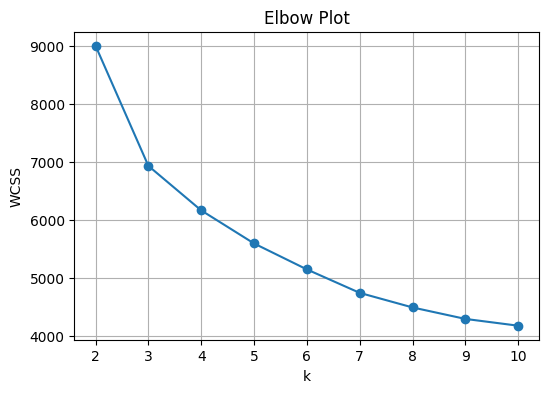

In [13]:
wcss = []
for k in range(2,11):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X)
    wcss.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2,11), wcss, marker='o')
plt.title("Elbow Plot")
plt.xlabel("k")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

#### B. Silhouette Plot

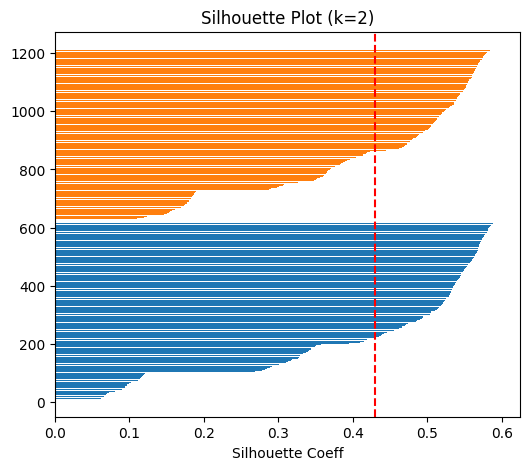

In [14]:
sil_vals = silhouette_samples(X, labels)
y_lower = 10

plt.figure(figsize=(6,5))
for i in range(2):
    cluster_vals = sil_vals[labels == i]
    cluster_vals.sort()
    y_upper = y_lower + len(cluster_vals)
    plt.barh(range(y_lower, y_upper), cluster_vals)
    y_lower = y_upper + 10

plt.axvline(sil_score, linestyle='--', color='red')
plt.title("Silhouette Plot (k=2)")
plt.xlabel("Silhouette Coeff")
plt.show()

#### C. PCA 2D Visualization

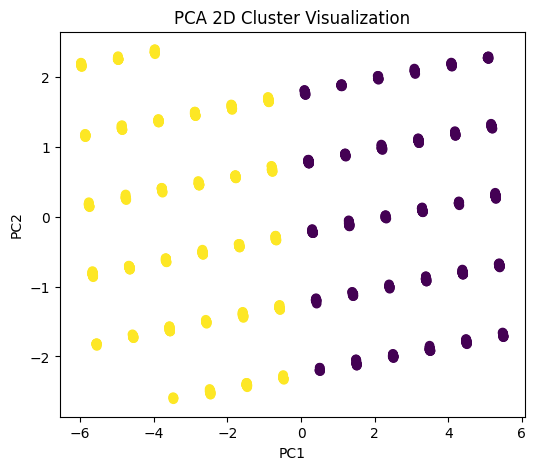

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis')
plt.title("PCA 2D Cluster Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#### D. Heatmap Rata-rata Numerik per Cluster

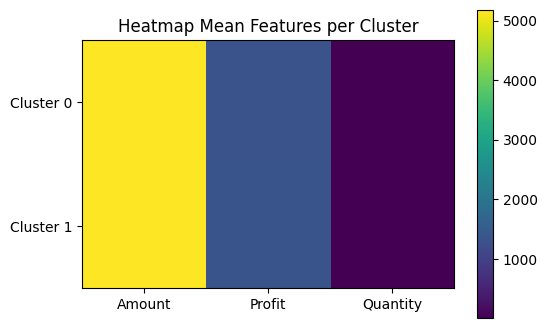

In [16]:
cluster_mean = df.groupby("cluster")[num_features].mean()

plt.figure(figsize=(6,4))
plt.imshow(cluster_mean, cmap="viridis")
plt.colorbar()
plt.xticks(range(len(num_features)), num_features)
plt.yticks([0,1], ["Cluster 0","Cluster 1"])
plt.title("Heatmap Mean Features per Cluster")
plt.show()